
# Week 5 Lab: From Aggregation to Visualization & Midterm Prep

<a href="https://colab.research.google.com/github/bradleyboehmke/uc-bana-4080/blob/main/labs/05_wk5_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lab builds directly on Week 4’s work with the `completejourney_py` dataset. We’ll take some aggregated results from last week and turn them into effective visualizations using **Pandas**, **Matplotlib**, and **Bokeh**. Then you’ll work through your own visualizations, and finally begin exploring ideas for your **midterm project**.

**Agenda**
- **Part 1 (10–15 min):** Instructor demo – from aggregation to visualization  
- **Part 2 (20–30 min):** Challenge – create visualizations for three business questions  
- **Part 3 (20–30 min):** Midterm exploration – brainstorm and investigate possible project ideas  

> **Sharing:** In Part 2, everyone should be prepared to share one visualization. We’ll call on a few groups.
>
> **Midterm Timing:** By the end of **Week 6’s lab**, you must have **approval** on your midterm business question. There are **no hard deliverables** due at the end of this lab, but you’re encouraged to discuss ideas today.


## Setup (run once)

In [2]:

# Core
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool

# Data
from completejourney_py import get_data

# Display Bokeh inline (Jupyter/Colab)
output_notebook()

# Load completejourney data
cj = get_data()
transactions = cj['transactions']
products = cj['products']
demographics = cj['demographics']

# Optional: set a clean default style for Matplotlib
plt.rcParams["figure.figsize"] = (8, 4.5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10


Loading BokehJS ...


📄 **Data dictionary:** https://bradleyboehmke.github.io/completejourney/articles/completejourney.html



## Part 1 — Demo: Visualizing Week 4 Aggregations (Instructor-led)

We’ll walk through three examples that show how to move from **aggregated data** to **clear visualizations**.



### 1A) Total **sales by product category** → Bar chart (Pandas)

**Idea:** Join transactions ↔ products to get `product_category`, aggregate sales per category, then plot the top categories.

**Why Pandas here?** It’s perfect for fast exploratory charts tied directly to a Series/DataFrame.


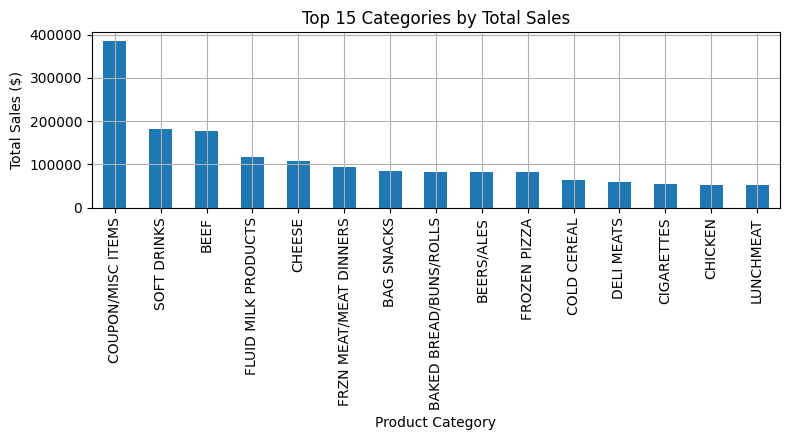

In [3]:

# Join transactions to products to bring in product_category
tx_prod = transactions.merge(
    products[["product_id", "product_category"]],
    on="product_id",
    how="left"
)

# Aggregate: total sales by product_category
sales_by_cat = (
    tx_prod
    .groupby("product_category", dropna=False)["sales_value"]
    .sum()
    .sort_values(ascending=False)
    .head(15)  # top 15 for readability
)

# Quick bar plot with Pandas
ax = sales_by_cat.plot(kind="bar")
ax.set_title("Top 15 Categories by Total Sales")
ax.set_xlabel("Product Category")
ax.set_ylabel("Total Sales ($)")
plt.tight_layout()
plt.show()



### 1B) **Monthly revenue trend** → Line chart (Matplotlib)

**Idea:** Convert timestamps → monthly periods and sum sales per month; plot with Matplotlib for finer control.

**Why Matplotlib here?** You get fine-grained control over styling, markers, and layout.


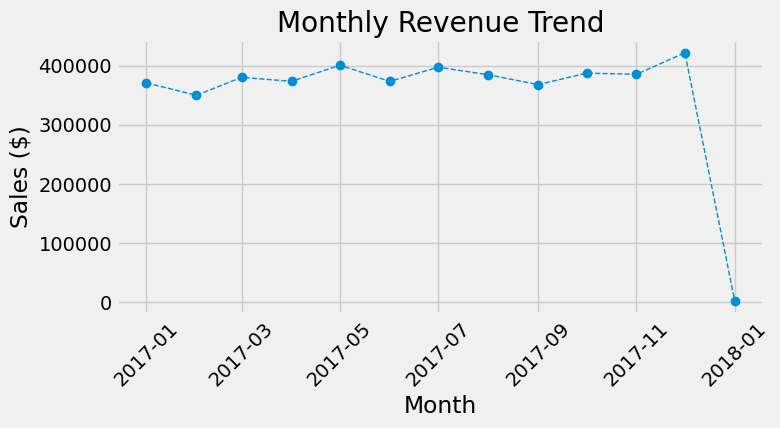

In [10]:

# Ensure transaction timestamp is datetime
# Aggregate to monthly sales (Month Start frequency)
monthly_sales = (
    transactions
    .set_index("transaction_timestamp")
    .resample("MS")["sales_value"]
    .sum()
    .rename("monthly_sales")
)

# set plot style
plt.style.use('fivethirtyeight')

# Matplotlib line chart with markers
fig, ax = plt.subplots()
ax.plot(monthly_sales.index, monthly_sales.values, linestyle="--", linewidth=1, marker="o")
ax.set_title("Monthly Revenue Trend")
ax.set_xlabel("Month")
ax.set_ylabel("Sales ($)")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()



### 1C) **Top 10 products by sales** → Interactive horizontal bar (Bokeh + hover)

**Idea:** Aggregate total sales by product, grab descriptions, and build an interactive bar chart with hover labels.

**Why Bokeh here?** Interactivity (hover, zoom, pan) and browser-based rendering—great for exploratory storytelling.  There's a lot more customization that could be done here -- see here for examples: https://docs.bokeh.org/en/latest/docs/user_guide/basic/bars.html


In [14]:
sales_by_product.head()

,product_id,sales_value,manufacturer_id,department,brand,product_category,product_type,package_size
0,6534178,303116.02,69,FUEL,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,None
1,6533889,27467.61,69,MISCELLANEOUS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,None
2,1029743,22729.71,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA
3,6534166,20477.54,69,MISCELLANEOUS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,None
4,6533765,19451.66,69,FUEL,Private,FUEL,GASOLINE-REG UNLEADED,None


In [21]:

# Aggregate: total sales by product
sales_by_product = (
    transactions
    .merge(products, on="product_id", how="left")
    .groupby("product_type")["sales_value"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Prepare categorical y-axis and values
factors = list(sales_by_product["product_type"].fillna("Unknown"))
values = list(sales_by_product["sales_value"])

# Bokeh figure (output_notebook() already called in Setup)
p = figure(
    y_range=factors,
    height=360,
    title="Top 10 Products by Sales (Interactive)",
    toolbar_location=None,
    tools=""
)

# Horizontal bars
p.hbar(y=factors, right=values, height=0.6)

# Add hover to show product name and formatted sales
hover = HoverTool(tooltips=[("Product", "@y"), ("Sales", "@right{$0,0.00}")])
p.add_tools(hover)

# other customizations
p.xaxis.axis_label = "Sales ($)"
p.yaxis.axis_label = "Product"
p.x_range.start = 0
show(p)



## Part 2 — Challenge: Answer Business Questions with Visualizations (20–30 min)

Work in small groups to answer **1 or more** of these three **business questions** using the `completejourney_py` data.

For each question:
1. Read the business question.  
2. Review the example **analytic approach** — this breaks the business problem into tangible steps you’ve learned so far.  
3. Use the provided analysis code to **generate the aggregated results** (code below purposely **does not** include plotting).  
4. **Your task:** Create a clear visualization of those results using **Pandas, Matplotlib, or Bokeh**.

💡 **Flexibility Note:** You are encouraged to **modify the analysis** if you have a different idea for exploring or visualizing the results. For example:
- **Question 1:** Instead of just comparing households with vs. without kids, you could break down **snack sales by the number of children** in the household.  
- **Question 2:** You could group similar product categories together to simplify the results.  
- **Question 3:** You could compare soft drink trends across weekdays or highlight seasonal peaks.

The goal is to answer the business question in a way that makes the insights clear.



### Business Question 1
**Do households with children purchase more snack products than households without children?**

**Analytic Approach**
- Join transactions ↔ products to get required product information.
- Filter transactions to include only products that fall under the `SNACKS` type.  
- Join transactions to the `demographics` dataset to identify households with children.  
- Create a binary indicator for presence of children.
- Aggregate total snack sales for households **with** vs. **without** children.


In [32]:

# Join products to get category
tx_prod = transactions.merge(products, on="product_id", how="left")

# Filter to snacks only
snack_sales = tx_prod[tx_prod['product_type'].str.contains('Snacks', case=False, na=False)]

# Join demographics to identify households with children
snack_demo = snack_sales.merge(demographics, on="household_id", how="left")

# Create a binary indicator for presence of children
snack_demo['has_kids'] = snack_demo['kids_count'] != '0'

# Aggregate total sales by presence of children
sales_by_children = (
    snack_demo
    .groupby("has_kids", as_index=False)
    .agg(total_sales=("sales_value", "sum"))
)

sales_by_children.head()


,has_kids,total_sales
0,False,15362.67
1,True,39544.67



### Business Question 2
**Which product categories generated the most revenue during December 2017?**

**Analytic Approach**
- Filter transactions for the month of **December 2017**.  
- Join transactions to products to get `product_category`.  
- Aggregate total sales by category.  
- Sort results to find the top categories.


In [34]:

# Filter to December 2017
december_tx = transactions[
    (transactions["transaction_timestamp"].dt.year == 2017) &
    (transactions["transaction_timestamp"].dt.month == 12)
]

# Join products for category
december_tx_prod = december_tx.merge(products, on="product_id", how="left")

# Aggregate sales by category
sales_by_category_dec = (
    december_tx_prod
    .groupby("product_category", as_index=False)
    .agg(total_sales=("sales_value", "sum"))
    .sort_values("total_sales", ascending=False)
)

sales_by_category_dec.head()


,product_category,total_sales
75,COUPON/MISC ITEMS,31878.31
255,SOFT DRINKS,14904.34
23,BEEF,14417.55
120,FLUID MILK PRODUCTS,10984.17
49,CHEESE,10581.36



### Business Question 3
**How has the quantity of soft drink purchases changed over time?**

**Analytic Approach**

- Join transactions to products to get product information.
- Filter transactions for products in the `SOFT DRINKS` category.  
- Aggregate quantity sold by month end (`"ME"`).  
- Look for upward or downward trends.


In [36]:

# Join products for category
tx_prod = transactions.merge(products[["product_id", "product_category"]],
                             on="product_id", how="left")

# Filter to soft drinks
soft_drinks = tx_prod[tx_prod["product_category"].str.contains("Soft drinks", case=False, na=False)].copy()

# Aggregate quantity by month
soft_drinks_monthly = (
    soft_drinks
    .set_index("transaction_timestamp")
    .resample("ME")["quantity"]
    .sum()
    .reset_index()
)

soft_drinks_monthly.head()


,transaction_timestamp,quantity
0,2017-01-31,7025
1,2017-02-28,7292
2,2017-03-31,8334
3,2017-04-30,7627
4,2017-05-31,8143



## Part 3 — Midterm Project Data Exploration (20–30 min)

### Scenario
You are a data scientist for **Regork**, a national grocery chain. Your manager has tasked you with identifying a potential growth area for the company to increase revenue and profits. You’ll present your findings and recommendations to the CEO.

### Your Task Today
- Explore the data to identify **possible business questions**.  
- Begin drafting ideas for your **midterm report**.  
- Think about both **business relevance** and **data feasibility**.  
- Use visualizations to uncover interesting trends or anomalies.

**Example directions**
- High-value demographic–product combinations (do certain products sell better to certain age groups?)
- Coupon redemption rates by demographic segment (are some segments more likely to use coupons?)
- Underserved demographic segments (are there customer segments that shop infrequently?)
- Positive/negative trends over time (are sales for certain products increasing or decreasing?)
- Product pairings that occur together frequently (do beer and diapers go together?)
- Seasonal or holiday-related spikes (do chips and salsa spike around the Super Bowl?)
- Marketing campaign or coupon effectiveness (did a recent campaign increase sales?)

**Midterm Timeline**
- By the end of **Week 6’s lab**: You must have **approval** on your business question.  
- This week: No hard deliverables, but you’re encouraged to discuss your ideas.
